# Gradient based iterative inverse design: Neural adjoint

For many problems, especially with large numbers of parameters, there may be many local minima in the fitness function for iterative inverse design. Even if very large numbers of initial guesses are used, there may be none close enough to the global optimum for a gradient based optimization to converge.

A possible approach is to use a two-step optimization: Start with global, population based optimization, and use the pre-optimized population after only a short optimization as initial set of geometries for the gradient based neural-adjoint loop.

We demonstrate this by using a neural adjoint loop with only few iterations and a low learning rate, such that it does not converge with random initialization. In a secnod step we then use evolutionary optimization from `nevergrad` to pre-optimize a population of $100$ geometries. The neural adjoint method with identical configuration then converges well on this pre-optimized set.

*Note* that for a better readibility of the tutorial, the neural adjoint parts are defined in the `helper` module.

In [1]:
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import nevergrad as ng
from concurrent import futures

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-07-05 16:17:19.143727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 16:17:19.630046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-05 16:17:20.732432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 16:17:20.749247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## load the training data

In [2]:
data_path = 'datasets/dataset1_random.h5'

# load data and scalers
x_train, x_test, y_train, y_test = helper.load_reflection_spectra_data(
    data_path)
wavelengths = np.linspace(500, 1500, 64)
scaler_mat, scaler_thick = pickle.load(
    open('{}_scalers.pkl'.format(os.path.splitext(data_path)[0]), 'rb'))

## load pre-trained forward model and freeze weights

The forward model is pre-trained, we do not want it to be modified (further trained) in the inverse net training. If the forward model was subject to further training, the inputs would loose their meaning as design parameters.
We therefore need to set the forward model as not trainable. 

*Note*: If a full model is set to `trainable = False`, the model needs to be compiled, for it to have an effect. Setting the model to `trainable = False` after compilation, this does not have any effect. To avoid recompilation, every single layer can be set to `trainable=False` in a loop through the model layers, which works also on compiled models without re-compilation.

In [3]:
model_path = 'models/fwd_model_resnet.h5'

# load pretrained forward model
fwd_model = keras.models.load_model(model_path)

2023-07-05 16:17:21.444331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 16:17:21.444533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 16:17:21.444655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Select a test-spectrum as inverse design target

For simplicity we take a test-sample spectrum

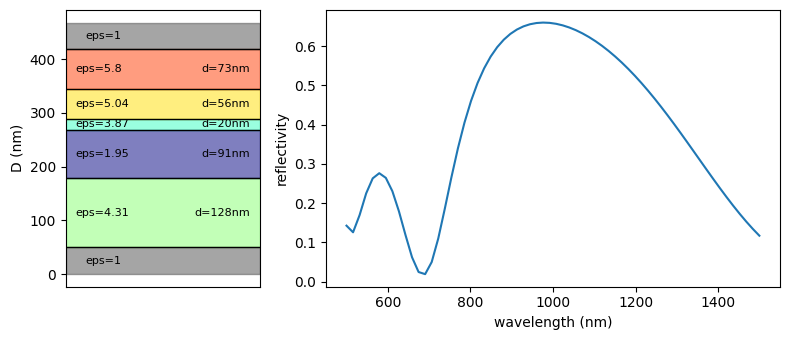

In [4]:
i_test = 23
target = y_test[i_test]

plt.figure(figsize=(8, 3.5))

plt.subplot(131)
helper.plot_stack_from_raw_predict(x_test[i_test], scaler_mat, scaler_thick)

plt.subplot2grid((1, 3), (0, 1), colspan=2)
plt.plot(wavelengths, y_test[i_test])
plt.xlabel("wavelength (nm)")
plt.ylabel("reflectivity")

plt.tight_layout()
plt.show()

## Run NA short, without pre-optimization

As reference, we run a first NA loop with random initial geometries. 

We deliberately use a low number of iterations and a small learning rate, so that the NA will not fully converge. In the next step we will run the same NA, but with a set of pre-optimized geometries.

In [5]:
# config NA run
N_epoch = 50
N_population = 100
weight_constraint_geo = 0.1
optimizer = keras.optimizers.Adam(learning_rate=0.1)    # the optimizer algo.

# generate random init population and run NA, deliberately start with a non-standardized distribution
init_geo = np.random.normal(
    5, 2, size=[N_population, x_train.shape[1], x_train.shape[2]])

# run the NA
loss_tot, inv_design_sorted = helper.do_NA(
    init_geo, target, optimizer=optimizer, fwd_model=fwd_model, 
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)


# --- Evaluate (best solutions)
# predict designs and their R-spectra (via forward model)
designs_predict = inv_design_sorted[:6]
mat_physical = scaler_mat.inverse_transform(designs_predict[..., 0])
thick_physical = scaler_thick.inverse_transform(designs_predict[..., 1])
y_recalc_no_preopt = helper.batch_calc_R(thick_physical, mat_physical, wavelengths)

  0%|          | 0/50 [00:00<?, ?it/s]2023-07-05 16:17:24.150371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-05 16:17:25.241556: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x56288e8abfb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-05 16:17:25.241582: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-05 16:17:25.244916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-05 16:17:25.356800: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-07-05 16:17:25.377395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix m

pymoosh: calculating R for 6 samples...


6it [00:00, 105.13it/s]


## Run global pre-optimization with `nevergrad`

*Note:* Here we need to use a population based optimization algorithm such as differential evolution.

In [14]:
# define optimization target: MSE between reflectivities
def fitness_func(geo, target_spec):
    # MSE between target and NN-predicted spectrum
    pred_spec = fwd_model.predict(geo, verbose=0)
    mse = np.mean(np.abs(pred_spec - target_spec)**2)
    return mse

# setup the nevergrad paramterization:
args_geo_ng = ng.p.Array(
    shape=[1, *fwd_model.input_shape[1:]],
    lower=-1.5, upper=1.5
)

# wrap optimized and fixed arguments together
instru = ng.p.Instrumentation(
    geo=args_geo_ng,     # optimization args (geometry)
    target_spec=target,  # additional (fixed) arg (design target spectrum)
)

# =============================================================================
# run optimization
# =============================================================================
N_population = 100
N_func_eval = 100

optim_algo = ng.families.DifferentialEvolution(crossover="twopoints", popsize=N_population)
NG_optimizer = optim_algo(instru, budget=N_func_eval, num_workers=30)

with futures.ThreadPoolExecutor(max_workers=30) as executor:
    x_opt = NG_optimizer.minimize(fitness_func, executor=executor, verbosity=0)

print('best fitness:', x_opt.loss)

best fitness: 0.04822893068194389


## Extract optimizer population

After a short global optimization run, we use the population of the global optimizer as initial set of test-solutions for the neural adjoint loop.

In [7]:
pop = NG_optimizer.population

# extract all designs in the pre-optimized population
init_geo_preopt = []
for k in pop:
    # each individual is a NG instrumentation. 
    # The fitness-func argument is `geo` --> get all values:
    geo_design = np.array(pop[k][1]['geo'].value)
    init_geo_preopt.append(geo_design[0])
init_geo_preopt = np.array(init_geo_preopt)

# Sort pre-optimized results and calculate the spectra of the 6 best (with pymoosh)
loss_total, init_geo_preopt_sorted = helper.sort_NA_results(
        tf.convert_to_tensor(init_geo_preopt, dtype=tf.float32), 
        target, weight_constraint_geo, fwd_model)

designs_init_preopt = init_geo_preopt_sorted.copy()[:6]
mat_physical_init_preopt = scaler_mat.inverse_transform(init_geo_preopt_sorted[..., 0])
thick_physical_init_preopt = scaler_thick.inverse_transform(init_geo_preopt_sorted[..., 1])
y_recalc_init_preopt = helper.batch_calc_R(thick_physical_init_preopt, mat_physical_init_preopt, wavelengths)

pymoosh: calculating R for 100 samples...


0it [00:00, ?it/s]

100it [00:00, 104.55it/s]


## Run the neural adjoint method

We run the NA with the same configuration as above, but instead of random initial geometries, we use the pre-optimized set of initial designs. With this initial set, the NA converges significantly faster.

In [8]:
# config NA run
N_epoch = 50
weight_constraint_geo = 0.1
optimizer = keras.optimizers.Adam(learning_rate=0.1)    # the optimizer algo.

# run the NA
loss_tot, inv_design_sorted_preopt = helper.do_NA(
    init_geo_preopt, target, optimizer=optimizer, fwd_model=fwd_model, 
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)

# evaluate best solutions
designs_predict_preopt = inv_design_sorted_preopt[:6]
y_predict_preopt = fwd_model.predict(designs_predict_preopt, verbose=0)
mat_physical_preopt = scaler_mat.inverse_transform(designs_predict_preopt[..., 0])
thick_physical_preopt = scaler_thick.inverse_transform(designs_predict_preopt[..., 1])
y_recalc_preopt = helper.batch_calc_R(thick_physical_preopt, mat_physical_preopt, wavelengths)

best: T-loss 1.08e-04, constraint_loss 2.62e-03, total 3.70e-04: 100%|██████████| 50/50 [00:01<00:00, 39.35it/s]


pymoosh: calculating R for 6 samples...


6it [00:00, 60.88it/s]


six best solutions from NA without pre-optimization


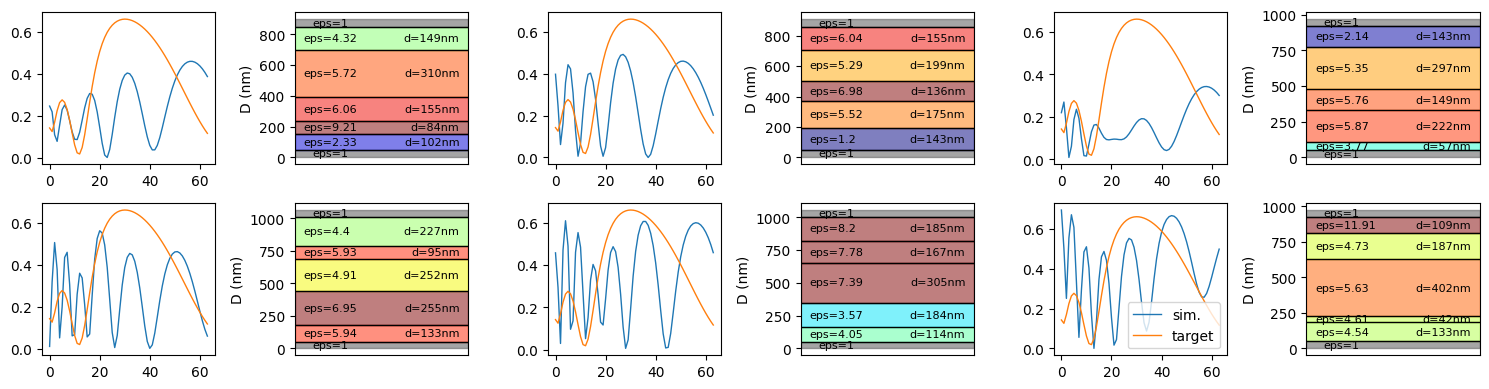

best solutions from pre-optimization


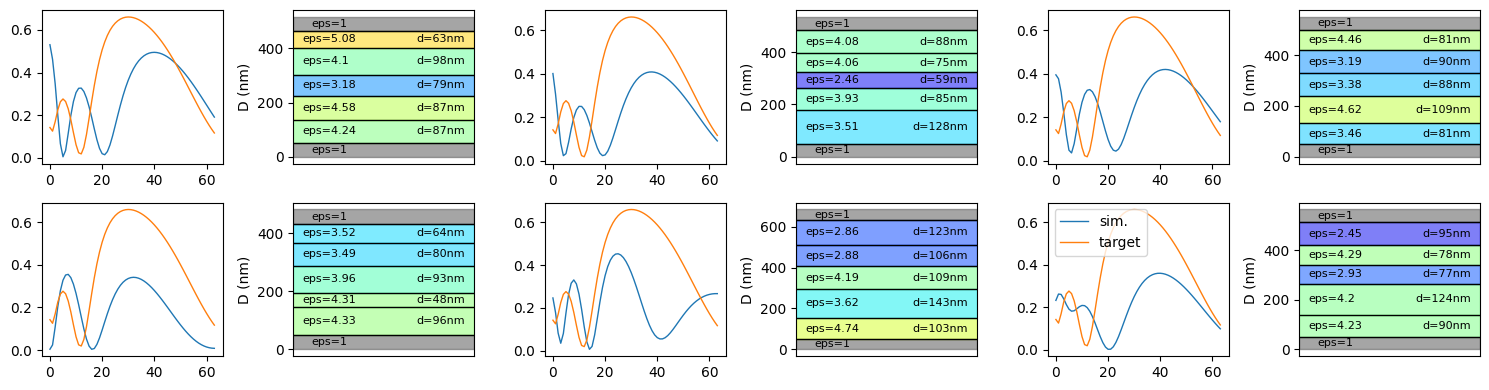

NA on pre-optimized design-set


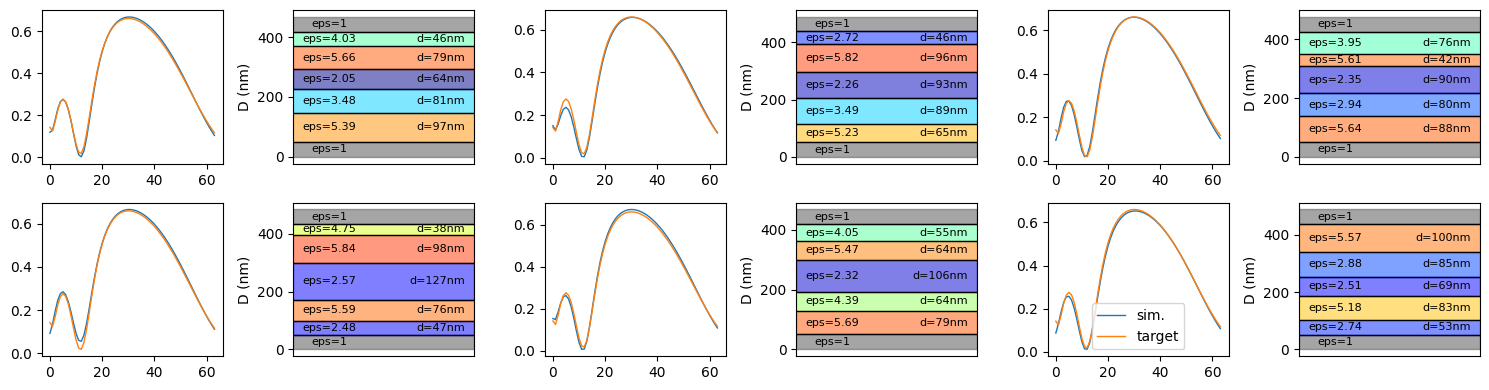

In [9]:

# plot the six best samples
print('six best solutions from NA without pre-optimization')
helper.plot_benchmark_R_samples(y_recalc_no_preopt, np.tile(target, (len(y_recalc_no_preopt), 1, 1)),
                                random_order=False, plot_design=True,
                                y_designs=designs_predict,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['sim.', 'target'])

# plot the six best samples
print('best solutions from pre-optimization')
helper.plot_benchmark_R_samples(y_recalc_init_preopt, np.tile(target, (len(y_recalc_init_preopt), 1, 1)),
                                random_order=False, plot_design=True,
                                y_designs=designs_init_preopt,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['sim.', 'target'])

# plot the six best samples
print('NA on pre-optimized design-set')
helper.plot_benchmark_R_samples(y_recalc_preopt, np.tile(target, (len(y_recalc_preopt), 1, 1)),
                                random_order=False, plot_design=True,
                                y_designs=designs_predict_preopt,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['sim.', 'target'])